# GP Toolbox for DEAP

Here we use DEAP to implement GP. This notebook is based on the *DEAP Algorithms (GA)* notebook we used earlier and only does a **single** run to keep thing simple.

GP is a lot more complex than GA so we will import more packages and do a bit more housekeeping before we run out algorithm.

Install DEAP.

In [122]:
!pip install deap

Import the DEAP tools and useful libraries . Notice this time we have some extra ones because of the symbolic nature of GP.

In [123]:
import operator
import math
import random

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp


import matplotlib.pyplot as plt

Set our Genetic Programming parameters.  Notice that these are virtually the same as the GA ones.

In [124]:
# Genetic Programming constants:
POPULATION_SIZE = 70
P_CROSSOVER = 0.7  # probability for crossover
P_MUTATION = 0.01   # probability for mutating an individual
MAX_GENERATIONS = 30
HALL_OF_FAME_SIZE = 10

Set the random seed.

In [125]:
RANDOM_SEED = 412
random.seed(RANDOM_SEED)

Because GP can mix and match operators and operands in an unconstrained way, we need to protect some our operators to prevent them from causing a crash.

In [126]:
# Define new functions
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1


def psin(n):
    try:
        return numpy.sin(n)
    except Exception:
        return numpy.nan

def pcos(n):
    try:
        return numpy.cos(n)
    except Exception:
        return numpy.nan

def pow2(n):
    return operator.pow(n, 2)

def protectedSqrt(n):
    return math.sqrt(n) if n >= 0 else 0  # Return 0 if input is negative

def protectedLog(n):
    return math.log(n) if n > 0 else 0  # Return 0 if input is non-positive

Add our functions and terminals.

In [127]:
# Create the primitive set with one input variable (z)
pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)

# Add the required mathematical functions
pset.addPrimitive(math.exp, 1)    # for e^(-z)
pset.addPrimitive(math.cos, 1)    # for cos(z)
pset.addPrimitive(math.sin, 1)    # for sin(z)
pset.addPrimitive(math.pow, 2)    # for powers, e.g., z^3

# Add ephemeral constants, e.g., random constants between -1 and 1
pset.addEphemeralConstant("rand101", lambda: random.randint(-1, 1))

# Rename the input variable to 'z'
pset.renameArguments(ARG0='x')

Define our fitness function. This one is a bit more involved than early examples for the GA, as we need to calculate the error. In this case we want to compare the returned (predicted) values from an individual compared to what **should** have been returned. If the error is huge (defined as > 1000 here), we put a ceiling of 1000 on it.


In [128]:
import numpy as np  # Add NumPy for better handling of numerical issues

def evalSymbReg(individual, points):
    # Transform the tree expression into a callable function
    func = toolbox.compile(expr=individual)
    sqerrors = []

    for x in points:
        try:
            # Calculate the target value using the given function
            # Using np.clip to ensure values stay within a valid range for operations
            cos_val = math.cos(x)
            sin_val = math.sin(x)

            # Ensure we don't use invalid values in our computations
            target_value = (
                math.exp(-x) *
                (x ** 3) *
                cos_val *
                sin_val *
                (cos_val * (sin_val ** 2) - 1)
            )

            result = func(x)  # Evaluate the individual's function

            # Compute the squared error
            sqerrors.append((result - target_value) ** 2)

        except ZeroDivisionError:
            sqerrors.append(1000)  # Assign a high error value for invalid evaluations
        except ValueError as e:
            print(f"Math domain error at x={x}: {e}")  # Print the error
            sqerrors.append(1000)  # Assign a high error value for invalid evaluations
        except Exception as e:
            print(f"Error evaluating at x={x}: {e}")  # Print the error
            sqerrors.append(1000)  # Assign a high error value for invalid evaluations

    # Calculate the mean squared error
    myError = math.fsum(sqerrors) / len(points)
    return min(myError, 1000),  # Return a tuple with an error cap of 1000


Create our toolbox. We have a number of key differences here, so pay attention to the following:

* In this case (and usually with Symbolic Regression in GP) we are looking to **minimize** error
* Our individuals are **trees** rather than lists
* Some operators, e.g. mutation, operate differently for GP so take them from the gp package


In [129]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=4)  # Increased max_ depth for initial population
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

# Adjust the evaluation points for a larger or more appropriate range
toolbox.register("evaluate", evalSymbReg, points=[x/10. for x in range(-50, 50)])  # Increased range

toolbox.register("select", tools.selTournament, tournsize=5)
toolbox.register("mate", gp.cxOnePoint)

# Increased max_ for mutation depth
toolbox.register("expr_mut", gp.genFull, min_=0, max_=6)  # Increased max_ depth for mutation
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# Static limits for tree height
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

Set up our population as before

In [130]:
population = toolbox.population(n=POPULATION_SIZE)
# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)


Create a statistics object. This time we're going to use the **MultiStatistics** tool because we want to record statistics about **size** as well as **fitness**.

In [131]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

Let's run our GP -- notice how it's almost the same as running the GA.

In [132]:
population, logbook = algorithms.eaSimple(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                               ngen=MAX_GENERATIONS, stats=mstats,
                               halloffame=hof, verbose=True)

Streaming output truncated to the last 5000 lines.
Math domain error at x=-4.6: math domain error
Math domain error at x=-4.5: math domain error
Math domain error at x=-4.4: math domain error
Math domain error at x=-4.3: math domain error
Math domain error at x=-4.2: math domain error
Math domain error at x=-4.1: math domain error
Math domain error at x=-3.9: math domain error
Math domain error at x=-3.8: math domain error
Math domain error at x=-3.7: math domain error
Math domain error at x=-3.6: math domain error
Math domain error at x=-3.5: math domain error
Math domain error at x=-3.4: math domain error
Math domain error at x=-3.3: math domain error
Math domain error at x=-3.2: math domain error
Math domain error at x=-3.1: math domain error
Math domain error at x=-2.9: math domain error
Math domain error at x=-2.8: math domain error
Math domain error at x=-2.7: math domain error
Math domain error at x=-2.6: math domain error
Math domain error at x=-2.5: math domain error
Math doma

Extract our statistcs. This time our logbook has *chapters* because we have maintained multiple statistics.

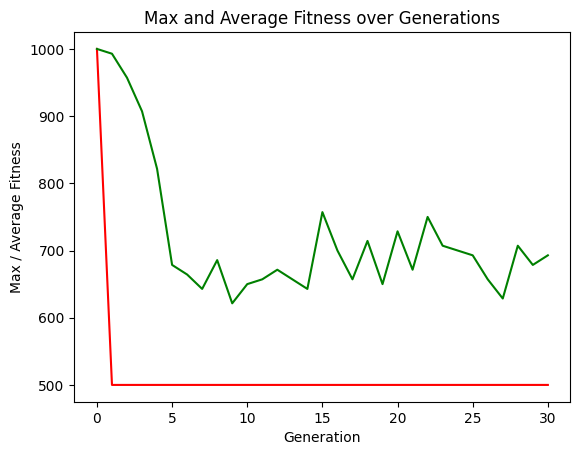

In [133]:
maxFitnessValues, meanFitnessValues = logbook.chapters['fitness'].select("min", "avg")

plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average Fitness over Generations')
plt.show()

Not much evolution going on here for the max fitness, but that's okay as this is an easy problem. What's important is that we can see that the average fitness decreases quickly too.